   # House Prices Prediction 

In this notebook we will be exploring the Ames Housing dataset, compiled by Dean De Cock for education purposes and available on Kaggle. The aim of this notebook is to build a predictive model based on the 79 explanatory variables to forecast the final price of a set of around 3000 houses located in Ames, Iowa (USA). 

The dataset contains both numerical and categorical features. Most of the features present missing values and are messy, so first of all we are going to do some clean-up so we can build our predictive models on the features without problem. 

Before starting crunching numbers, some of the notebooks I've used as inspiration were:
1. [A study on Regression applied to the Ames dataset](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset) by Pedro Marcelino 
2. [Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models) by Alexandru Papiu 
3. [Stacked Regressions to predict House Prices](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/notebook) by Serigne 

In [73]:
### House Prices: Regression Prediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
from scipy import stats
from scipy.stats import norm, skew

# Dataset importation 
train = pd.read_csv('D:/Second Desktop/Data Science/Datasets/Householder/train.csv')
test = pd.read_csv('D:/Second Desktop/Data Science/Datasets/Householder/test.csv')

First, let's drop the Id column and see the size of the two datasets.

In [74]:
train = train.drop('Id', axis = 'columns')
test = test.drop('Id', axis = 'columns')

# Print dataset sizes
print('The size of Train sample is {} rows and {} columns'.format(train.shape[0], train.shape[1]))
print('The size of Test sample is {} rows and {} columns'.format(test.shape[0], test.shape[1]))

The size of Train sample is 1460 rows and 80 columns
The size of Test sample is 1459 rows and 79 columns


## 1. EDA

In this part of the analysis we will be exploring the following characteristics of the dataset:
1. Outliers
2. Missing values
3. Skewness of the data 

### 1. Outliers

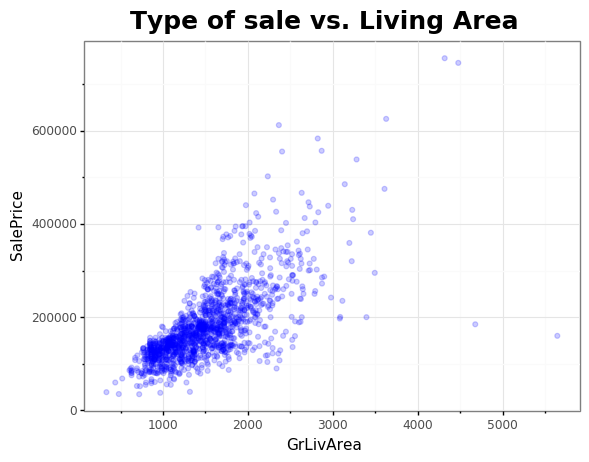

<ggplot: (-9223371878583937684)>

In [75]:
# Exploring outliers
(
    ggplot(train) +
        aes(x = 'GrLivArea', y = 'SalePrice') +
        geom_point(alpha = .2, color = 'blue') +
        theme_bw() +
        theme(plot_title = element_text(size = 18, face = 'bold')) +
        ggtitle('Type of sale vs. Living Area')
)

There are a few outliers corresponding to exclusive houses. These are rare compared to the average, so they look like outliers on the plot. Let's see how would look the same plot removing those outliers.

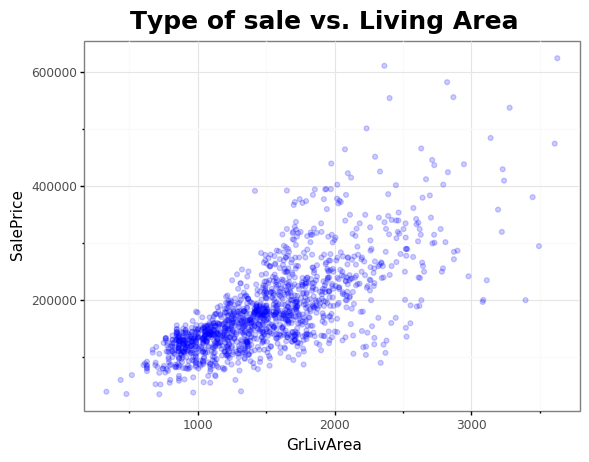

<ggplot: (-9223371878583658588)>

In [76]:
# Better removing 
train = train.drop(train[train['GrLivArea'] > 4000].index)
(
    ggplot(train) +
        aes(x = 'GrLivArea', y = 'SalePrice') +
        geom_point(alpha = .2, color = 'blue') +
        theme_bw() +
        theme(plot_title = element_text(size = 18, face = 'bold')) +
        ggtitle('Type of sale vs. Living Area')
)

    Apart from the presence of outliers, it seems like the skewness of the data is gonna be an issue as well, so before taking any action on the outliers, let's analyse the skewness of the features.

### 2. Skewness

We will start this part of the analysis with the target variable (Sale Price).

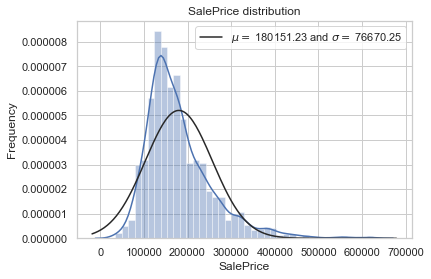

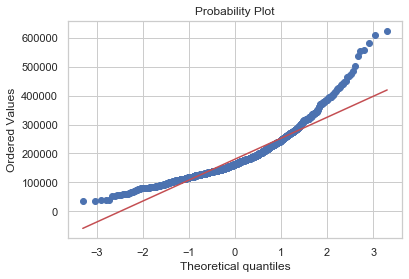

In [77]:
# target variable (SalePrice)
sns.distplot(train['SalePrice'], fit = norm)
(mu, sigma) = norm.fit(train['SalePrice'])  # get the fitted parameters

plt.legend(['$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)])
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot = plt)
plt.show()

The dataset shows a high positive skewness. Since the values are positive we can apply a Box-Cox transformation of the data and see how it looks.

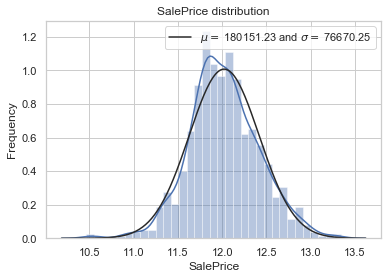

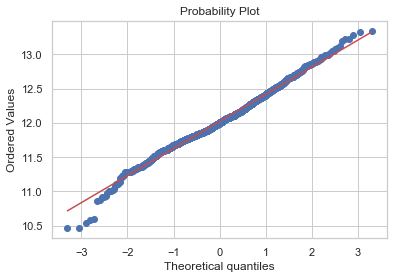

In [78]:
train['SalePrice'] = np.log1p(train['SalePrice'])  # Logaritmic transformation
# Replot the new distribution
sns.distplot(train['SalePrice'], fit = norm)

plt.legend(['$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)])
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot = plt)
plt.show()

There are still a few outliers, but the distribution looks much more normal now. We will deal with the skewness and outliers of the rest of the variables later on, after having merged train and test datasets.

### 3. Missing Values

Text(0.5, 1.0, 'Missing Values Proportion by Feature')

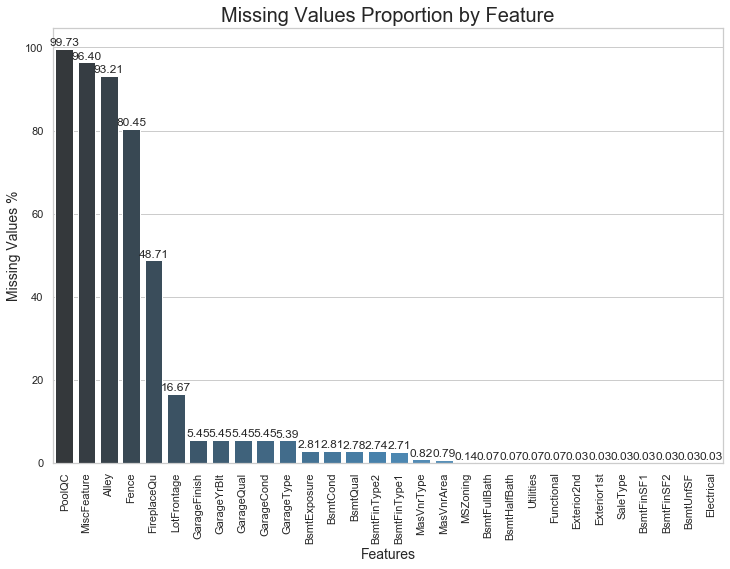

In [79]:
# Save ID and drop from original dataset
train_id = train.shape[0]  # guardar numero de files per a dividir el dataset que anem a juntar 
#test_id = test.shape[0]
y_train = train.SalePrice.values # save as a vector 

# Concatenate train and test
merged = pd.concat((train, test)).reset_index(drop = True)
merged.drop(["SalePrice"], axis = 1, inplace = True) # remove target variable

merged_na = (merged.isnull().sum() / len(merged)) * 100
merged_na = merged_na.drop(merged_na[merged_na == 0].index).sort_values(ascending = False)[:30]
# merged_na = pd.DataFrame({'Missing Ratio':merged_na})   # to print if necessary
# Plot missing values 
f, ax = plt.subplots(figsize = (12, 8))
plt.xticks(rotation = '90')
sns.set(style = "whitegrid")
# Add color palette
splot = sns.barplot(x = merged_na.index, y = merged_na, palette="Blues_d")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'center', xytext = (0, 6), textcoords = 'offset points')
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Missing Values %', fontsize = 14)
plt.title('Missing Values Proportion by Feature', fontsize = 20)

There are a few features with a high proportion of missing values. According to the documentation of the dataset, these are not really missing values, but categories than can be relabeled. In the case of real missing values we are gonna fill the gaps with the median in numerical variables and the mode in the case of categorical features.

In [80]:
# NA means "None" in the variables below, so let's recode the variables accordingly
to_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish',
          'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
          'BsmtFinType2', 'MasVnrType', 'MSSubClass']
merged[to_none] = merged[to_none].fillna('None')

# Fill NA with media
merged['LotFrontage'] = merged.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# The same but with a categorical value using the mode
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType'):
    merged[col] = merged[col].fillna(merged[col].mode()[0])

# Replace NA with 0 in the numerical variables
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
           'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    merged[col] = merged[col].fillna(0)
    
# Remove categories with low variance
merged = merged.drop(['Utilities'], axis = 1)

# Fill with Typical
merged['Functional'] = merged['Functional'].fillna('Typ')

# Convert pseudo-numerical variables to categorical 
for i in ('MSSubClass', 'OverallCond'):
    merged[i] = merged[i].astype(str)
    
# Check again for missing values 
merged_na = (merged.isnull().sum() / len(merged)) * 100
missing = pd.DataFrame({'Missing Ratio' :merged_na})
missing.head()

,Missing Ratio
MSSubClass,0.0
MSZoning,0.0
LotFrontage,0.0
LotArea,0.0
Street,0.0


All clean now. We are good to go!





## B. Feature Engineering

In this section we are gonna brush up the merged dataset to make the most of the available data. First up, we need to do something with the skewness and outlier presence across most of the features. 

In [81]:
from sklearn import preprocessing 
# Frist, create a new feature adding the total area of the building 
# (basement + ground floor + first floor)
merged['TotalSF'] = merged['TotalBsmtSF'] + merged['1stFlrSF'] + merged['2ndFlrSF']

# Check skewness: where values between -0.5 and 0.5 are ideal and below -1 above 1 are too skewed
# Pick numeric columns
num_cols = merged.dtypes[merged.dtypes != 'object'].index
# Yeo-Johnson transformation (extended Box-cox transformation)
skewness = pd.DataFrame({
    'Skew': merged[num_cols].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending = False)
})
skewness = skewness[abs(skewness.Skew) > 0.75]
skewness

,Skew
MiscVal,21.932147
PoolArea,18.701829
LotArea,13.123758
LowQualFinSF,12.080315
3SsnPorch,11.368094
KitchenAbvGr,4.298845
BsmtFinSF2,4.142863
EnclosedPorch,4.000796
ScreenPorch,3.943508
BsmtHalfBath,3.942892


We can't use a Min-Max or Max Abs scaler to deal with the skewness given that the outliers would affect to the ranges. We need a more robust technique such as the Power Transformer.

In [82]:
# Yeo-Johnson transformation
from sklearn.preprocessing import PowerTransformer
yeo_johnson_lambdas = [] 
pt = PowerTransformer()
for numeric_feat in num_cols:
    merged[numeric_feat] = pt.fit_transform(merged[[numeric_feat]])
    yeo_johnson_lambdas.append(pt.lambdas_[0])
merged

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF
0,60,RL,-0.155417,-0.136307,Pave,None,Reg,Lvl,Inside,Gtl,...,-0.061546,None,None,None,-0.191386,-1.642103,0.158154,WD,Normal,0.132876
1,20,RL,0.544867,0.117836,Pave,None,Reg,Lvl,FR2,Gtl,...,-0.061546,None,None,None,-0.191386,-0.400584,-0.602578,WD,Normal,0.078138
2,60,RL,-0.011096,0.440019,Pave,None,IR1,Lvl,Inside,Gtl,...,-0.061546,None,None,None,-0.191386,1.019813,0.158154,WD,Normal,0.311223
3,70,RL,-0.401347,0.107347,Pave,None,IR1,Lvl,Corner,Gtl,...,-0.061546,None,None,None,-0.191386,-1.642103,-1.364659,WD,Abnorml,0.010865
4,60,RL,0.723430,0.934927,Pave,None,IR1,Lvl,FR2,Gtl,...,-0.061546,None,None,None,-0.191386,1.986309,0.158154,WD,Normal,1.054480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2910,160,RM,-2.683040,-2.769638,Pave,None,Reg,Lvl,Inside,Gtl,...,-0.061546,None,None,None,-0.191386,-0.026890,-1.364659,WD,Normal,-1.249541
2911,160,RM,-2.683040,-2.804939,Pave,None,Reg,Lvl,Inside,Gtl,...,-0.061546,None,None,None,-0.191386,-0.790991,-1.364659,WD,Abnorml,-1.249541
2912,20,RL,3.689973,1.669564,Pave,None,Reg,Lvl,Inside,Gtl,...,-0.061546,None,None,None,-0.191386,1.019813,-1.364659,WD,Abnorml,-0.022443
2913,85,RL,-0.302131,0.287548,Pave,None,Reg,Lvl,Inside,Gtl,...,-0.061546,None,MnPrv,Shed,5.225033,0.333068,-1.364659,WD,Normal,-0.844700


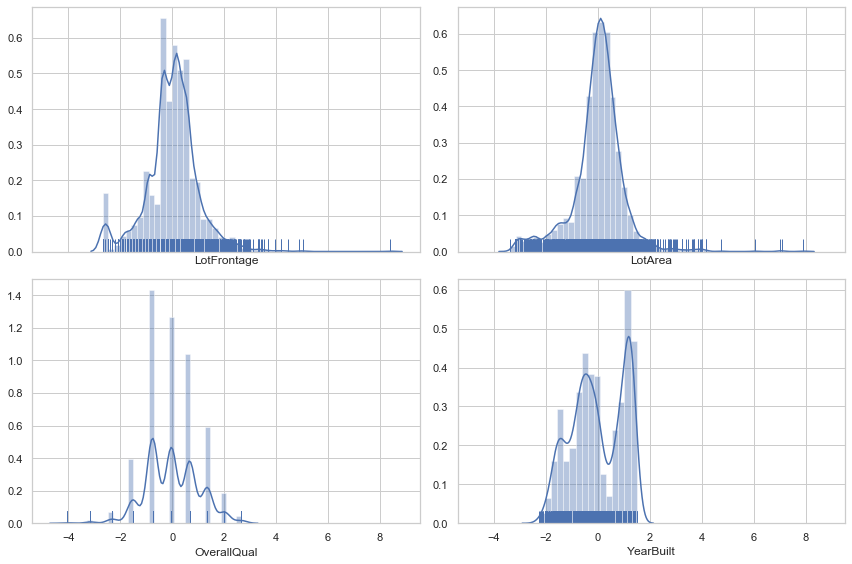

In [83]:
# Visualize the changes in distributions
to_plot = ['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt']

sub_merged = merged[to_plot]
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8), sharex = True)
sns.distplot(merged['LotFrontage'], rug = True, ax = axes[0, 0])
sns.distplot(merged['LotArea'], rug = True, ax = axes[0, 1])
sns.distplot(merged['OverallQual'], rug = True, ax = axes[1, 0])
sns.distplot(merged['YearBuilt'], rug = True, ax = axes[1, 1])

plt.tight_layout()

All the features in the dataset are now normalized. Now we will turn our attention to the correlation between variables.

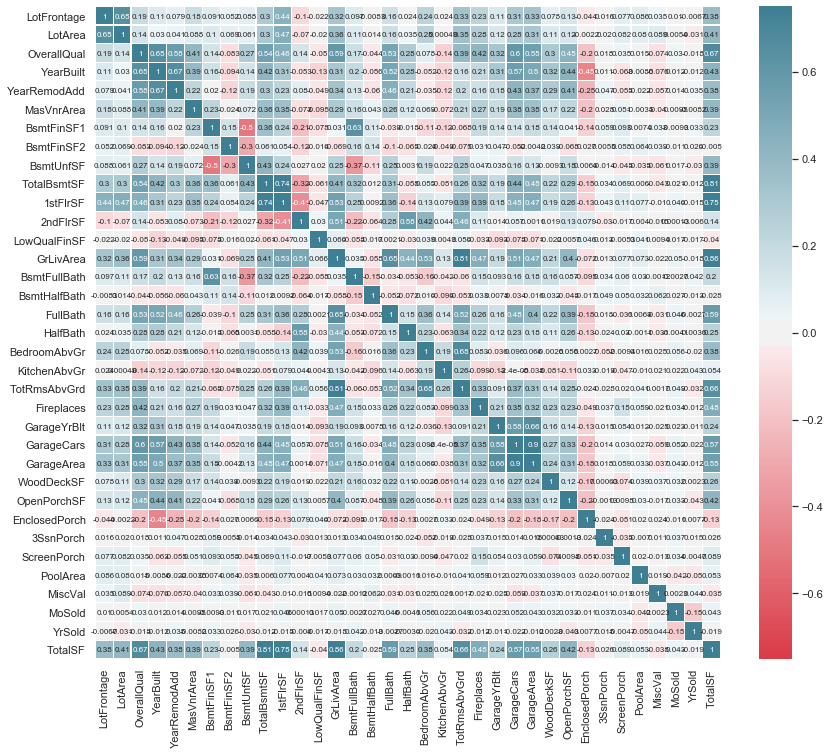

In [84]:
# Correlation map before hot-encoding 
def correlation_heatmap(df, center = None):
    fig, ax = plt.subplots(figsize = [14, 12])
    colormap = sns.diverging_palette(10, 220, as_cmap = True)
    fig = sns.heatmap(df.corr(),
                     cmap = colormap,
                     center = center,
                     annot = True,
                     linewidths = 0.1,
                     vmin = -0.75, vmax = 0.75, # to spot significant features
                     annot_kws = {'fontsize':8})
num_cols = merged.dtypes[merged.dtypes != 'o'].index
correlation_heatmap(merged[num_cols], center = 0)

There are a few categorical variables we need to deal with. We are gonna Hot-Encode them so we can use them in any model. We'd rather used this method rather than Label-Encoding in order to avoid the cardinality problem we would have in models like XGBoosting or LightGBM.

In [85]:
# Hot-encode of the variables
merged = pd.get_dummies(merged)
print('The final number of features after the Hot-Enconding is {}'.format(merged.shape[1]))

The final number of features after the Hot-Enconding is 323


### 1. Low variance features removal

Now we have the complete dataset we are gonna pass through our models, we need to check whether they are informative enough or they are just adding noise to our model. And not only that: since now we're working with a dataset with more than 300 features, this is gonna give us trouble when running some algorithms like the Cross-Validation of models or when tunning them. 

In [91]:
### LOW VARIANCE FEATURES REMOVAL
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold = 0.01)
sel_var = constant_filter.fit_transform(merged)
merged = merged[merged.columns[constant_filter.get_support(indices = True)]]

print('The final number of features is {}'.format(merged.shape[1]))

The final number of features is 228


In [92]:
# Train-test split
train = merged[:train_id]
test = merged[train_id:]

95 features were removed because of their low variance (they wouldn't add any information to the models). Let's do now the Feature Selection to brush up our dataset even further.

### 2. Feature Selection 

We're gonna ranking the features according to how much information they provide to the model. To do this, we're gonna use the following methods:
1. Univariate ANOVA (F-statistic)
2. Decision Tree Regressor
3. RFE (Recursive Feature Elimination), based on a nested lineal SVR model.

In [93]:
# UNIVARIATE ANOVA
from sklearn.feature_selection import SelectKBest, f_classif

# criteri chi2 necessita que tots els valors siguen positius. f_classif no te esta limitacio (ANOVA-F value)
#apply SelectKBest class to extract top 50 best features
bestfeatures = SelectKBest(score_func = f_classif, k = 50)
fit = bestfeatures.fit(train.values, y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(50,'Score'))  #print 10 best features

                     Specs     Score
134           ExterQual_Ex  6.187987
2              OverallQual  5.687676
222           SaleType_New  5.560320
34                 TotalSF  5.365206
227  SaleCondition_Partial  5.128192
78    Neighborhood_NridgHt  4.497174
191         FireplaceQu_Ex  4.145911
145            BsmtQual_Ex  4.017742
183         KitchenQual_Ex  3.877273
13               GrLivArea  3.376843
77    Neighborhood_NoRidge  3.222490
23              GarageCars  2.939364
9              TotalBsmtSF  2.866878
137           ExterQual_TA  2.853283
136           ExterQual_Gd  2.759549
3                YearBuilt  2.686416
16                FullBath  2.601314
24              GarageArea  2.520949
10                1stFlrSF  2.349500
123    Exterior2nd_CmentBd  2.294668
113    Exterior1st_CemntBd  2.219800
144        Foundation_Slab  2.210563
186         KitchenQual_TA  2.145912
133       MasVnrType_Stone  2.133438
83    Neighborhood_Somerst  2.119487
223            SaleType_WD  2.108152
1

In [97]:
# Decision Tree Regression Classifier 
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(train.values, y_train)
importance = model.feature_importances_
importance[::-1].sort()
# summarize feature importance
for i,v in enumerate(importance):
    if v > 0.001:
        print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#sns.barplot([x for x in range(len(importance))], importance, color="#1E7F00")

Feature: 0, Score: 0.48468
Feature: 1, Score: 0.26863
Feature: 2, Score: 0.03097
Feature: 3, Score: 0.02354
Feature: 4, Score: 0.01610
Feature: 5, Score: 0.01343
Feature: 6, Score: 0.01221
Feature: 7, Score: 0.00905
Feature: 8, Score: 0.00892
Feature: 9, Score: 0.00870
Feature: 10, Score: 0.00754
Feature: 11, Score: 0.00720
Feature: 12, Score: 0.00690
Feature: 13, Score: 0.00676
Feature: 14, Score: 0.00592
Feature: 15, Score: 0.00529
Feature: 16, Score: 0.00356
Feature: 17, Score: 0.00327
Feature: 18, Score: 0.00296
Feature: 19, Score: 0.00294
Feature: 20, Score: 0.00257
Feature: 21, Score: 0.00253
Feature: 22, Score: 0.00236
Feature: 23, Score: 0.00230
Feature: 24, Score: 0.00220
Feature: 25, Score: 0.00219
Feature: 26, Score: 0.00210
Feature: 27, Score: 0.00198
Feature: 28, Score: 0.00195
Feature: 29, Score: 0.00194
Feature: 30, Score: 0.00192
Feature: 31, Score: 0.00191
Feature: 32, Score: 0.00167
Feature: 33, Score: 0.00163
Feature: 34, Score: 0.00152
Feature: 35, Score: 0.00151
Fe

In [98]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

# feature extraction
model = SVR(kernel="linear") 
#from sklearn.linear_model import LogisticRegression
# LogisticRegression(solver='lbfgs')  for categorical variables  
rfe = RFE(model, n_features_to_select = 50) # let's try to create a model with 50 features
fit = rfe.fit(train.values, y_train)

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 50
Selected Features: [False  True  True  True False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False  True False
  True  True False False False False False False False  True  True  True
  True False False False False False False False False False False False
 False False False  True  True False False False  True  True  True  True
  True  True  True  True  True False False  True False  True  True False
  True  True False False  True  True False False False  True False False
 False False False False False  True False  True  True  True  True  True
 False False False False  True False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False  True
 False False Fa

After having fitted the RFE model, we can rank the features according to the information in them. 

In [99]:
for i in range(merged.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, fit.support_[i], fit.ranking_[i]))

Column: 0, Selected False, Rank: 179.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected False, Rank: 62.000
Column: 5, Selected False, Rank: 98.000
Column: 6, Selected False, Rank: 89.000
Column: 7, Selected False, Rank: 63.000
Column: 8, Selected False, Rank: 13.000
Column: 9, Selected False, Rank: 129.000
Column: 10, Selected False, Rank: 142.000
Column: 11, Selected False, Rank: 141.000
Column: 12, Selected False, Rank: 176.000
Column: 13, Selected True, Rank: 1.000
Column: 14, Selected False, Rank: 122.000
Column: 15, Selected False, Rank: 159.000
Column: 16, Selected False, Rank: 80.000
Column: 17, Selected False, Rank: 81.000
Column: 18, Selected False, Rank: 169.000
Column: 19, Selected False, Rank: 155.000
Column: 20, Selected False, Rank: 168.000
Column: 21, Selected False, Rank: 160.000
Column: 22, Selected False, Rank: 61.000
Column: 23, Selected False, Rank: 86.000
Column: 24, Selected Fa

Now, with this information we can drop the features that are not meaningful and keep the rest to fit the models.

In [100]:
to_fit = np.array(fit.support_)
merged = merged.iloc[:,to_fit]

## MODELLING

First things first, we need to stablish a Cross-Validation model so we can gain insight into which is the best model for this dataset. Given the size of the dataset, a K-fold method would be the best strategy over other methodologies. 

In [104]:
### MODELLING
#from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

# Cross-validation strategy
k_folds = 5
def rmsle_cv(model):
    kf = KFold(k_folds, shuffle = True, random_state = 42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring = 'neg_mean_squared_error',
                                   cv = kf))
    return rmse

Given the number of features and the characteristics of the dataset, the models we will use are:
1. XGBoost
2. LightGBM
3. Gradient Boosting Regressor

In [116]:
# XGBoost model
house_xgb = xgb.XGBRegressor(colsample_bytree = 0.5, gamma = 0.05, 
                             learning_rate = 0.05, max_depth = 3, 
                             min_child_weight = 1.8, n_estimators = 2200,
                             reg_alpha = 0.5, reg_lambda = 0.8,
                             subsample = 0.5, 
                             random_state = 7, nthread = -1,
                             verbosity = 0)

# LightGBM
house_lgb = lgb.LGBMRegressor(objective = 'regression', num_leaves = 5,
                              learning_rate = 0.05, n_estimators = 720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed = 9, bagging_seed = 9,
                              min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11)

# Gradient Boosting Regressor
house_gboost = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05,
                                   max_depth = 4, max_features = 'sqrt',
                                   min_samples_leaf = 15, min_samples_split = 10, 
                                   loss = 'huber', random_state = 5)

And now let's see which model is performing better.

In [117]:
score = rmsle_cv(house_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(house_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

score = rmsle_cv(house_gboost)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

Xgboost score: 0.1185 (0.0051)

LGBM score: 0.1169 (0.0044)

LGBM score: 0.1166 (0.0063)



## Model Stacking

We can improve the precision of our model even further with a stacking algorithm. To check whether this would be a good solution, first we're gonna try with the average of the three previous models.

In [118]:
# Object definition. Inspired on the script of Serigne (2017) available on Kaggle.
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

# Avereged base models score
averaged = AveragingModels(models = (house_xgb, house_lgb, house_gboost))
score = rmsle_cv(averaged)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: 0.1139 (0.0053)



The RMSE dropped to 0.1139 (std = 0.0053)